In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
from tqdm import tqdm
from utils import*
import gc
import scipy as scipy

from scipy.sparse import csc_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# .Obj file handling part

In [2]:
points_c=get_file_obj("./data/dargon.obj")

In [3]:
print(points_c.shape)

torch.Size([100250, 6])


In [4]:
dico=dict()
bord=get_borders(points_c)

create_quadtree(dico,0,11,points_c,bord,"")
print(len(dico))

430752


In [5]:
bord=get_borders(points_c)

In [6]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

def get_dico_final(dico,D):
    new_dico=dict()

    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):

            for i in range(1,9):
                tmp_node=node[:-1]+str(i)
                new_dico[tmp_node]=dico[tmp_node]
    return new_dico
        

def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,6))
    o_s=torch.ones((nb_s,8,5)) #interpolation weight , width , center
    L_indexes=dict()
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,border_father,l_points=dico[node]

            for p in l_points:
                s_p[cpt_p]=p.clone()

                gx,dx,gy,dy,gz,dz=border_father

                tmp_o_vec=torch.empty((8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    w=(s_p[cpt_p,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[7,0]=u*(1-v)*(1-w)
                        
                
                
                
                o_s[cpt_p]=tmp_o_vec.clone()

                ancestor=node[:-2]
                
                
                if ancestor=="":
                    ancestor=node

                if ancestor in L_indexes:
                    L_indexes[ancestor][0].append(cpt_p)
                else:
                    _,new_c,_,_,_,_=dico[ancestor]
                    L_indexes[ancestor]=([cpt_p],new_c)
                    
                
                cpt_p+=1
    return s_p,o_s,L_indexes


def get_V_tmp(coords_grid,l_o,l_s):
    #q [ r_x , r_y , r_z,  3 ]
    #     0    1     2    3

    q=coords_grid.clone().unsqueeze(3).unsqueeze(4).repeat(1,1,1,l_o.shape[0],8,1).to(device) 
    #q [ r_x , r_y , r_z, l_o , 8 , 3 ]
    #     0     1     2    3    4   5

    q[:,:,:,:,:,0]-=l_o[:,:,2]
    q[:,:,:,:,:,0]/=l_o[:,:,1]
    q[:,:,:,:,:,1]-=l_o[:,:,3]
    q[:,:,:,:,:,1]/=l_o[:,:,1]
    q[:,:,:,:,:,2]-=l_o[:,:,4]
    q[:,:,:,:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q)**2,dim=5)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    

    res=l_s[:,3:].clone().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device) 
    res=res.repeat(coords_grid.shape[0],coords_grid.shape[1],coords_grid.shape[2],1,8,1).to(device) 
    



    res[:,:,:,:,0,0]*=test[:,:,:,:,0]
    res[:,:,:,:,0,1]*=test[:,:,:,:,0]
    res[:,:,:,:,0,2]*=test[:,:,:,:,0]
    res[:,:,:,:,1,0]*=test[:,:,:,:,1]
    res[:,:,:,:,1,1]*=test[:,:,:,:,1]
    res[:,:,:,:,1,2]*=test[:,:,:,:,1]
    res[:,:,:,:,2,0]*=test[:,:,:,:,2]
    res[:,:,:,:,2,1]*=test[:,:,:,:,2]
    res[:,:,:,:,2,2]*=test[:,:,:,:,2]
    res[:,:,:,:,3,0]*=test[:,:,:,:,3]
    res[:,:,:,:,3,1]*=test[:,:,:,:,3]
    res[:,:,:,:,3,2]*=test[:,:,:,:,3]
    res[:,:,:,:,4,0]*=test[:,:,:,:,4]
    res[:,:,:,:,4,1]*=test[:,:,:,:,4]
    res[:,:,:,:,4,2]*=test[:,:,:,:,4]
    res[:,:,:,:,5,0]*=test[:,:,:,:,5]
    res[:,:,:,:,5,1]*=test[:,:,:,:,5]
    res[:,:,:,:,5,2]*=test[:,:,:,:,5]
    res[:,:,:,:,6,0]*=test[:,:,:,:,6]
    res[:,:,:,:,6,1]*=test[:,:,:,:,6]
    res[:,:,:,:,6,2]*=test[:,:,:,:,6]
    res[:,:,:,:,7,0]*=test[:,:,:,:,7]
    res[:,:,:,:,7,1]*=test[:,:,:,:,7]
    res[:,:,:,:,7,2]*=test[:,:,:,:,7]

    
    
    res=torch.sum(res,dim=(3,4)).to(device) 
   
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )


# Computation of the vector field

In [82]:
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_vec(points_c,dico,D,batch_size=32,bgrid=32,resolution=32,desc=None,name=None):
    
    l_s,l_o,indexes=get_os(points_c.shape[0],dico,D)

    #batch_size=32
    #bgrid=32

    

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()
    
    
    width_x=max_x-min_x
    width_y=max_y-min_y
    width_z=max_z-min_z

    size_grid_x=width_x/resolution
    size_grid_y=width_y/resolution
    size_grid_z=width_z/resolution
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)

    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    grid_res=torch.zeros((resolution,resolution,resolution,3))
    
    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z
    
    

    

    
    for key in tqdm(indexes,desc=desc):
        tmp_l,tmp_c=indexes[key]
        for i in range(0,len(tmp_l),batch_size):

           

         

            batch_idxs=tmp_l[i:i+batch_size]
            

            tmp_l_s=l_s[batch_idxs].to(device) 
            tmp_l_o=l_o[batch_idxs].to(device)
    
            c_x_g = ((torch.min(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)
            c_y_g = ((torch.min(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)
            c_z_g = ((torch.min(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)

            c_x_d = ((torch.max(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)+bgrid
            c_y_d = ((torch.max(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)+bgrid
            c_z_d = ((torch.max(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)+bgrid

            c_x_g=max(0,c_x_g-bgrid)
            c_y_g=max(0,c_y_g-bgrid)
            c_z_g=max(0,c_z_g-bgrid)
            
            tmp_grid=grid_coords[c_x_g:c_x_d,c_y_g:c_y_d,c_z_g:c_z_d].to(device)
            tmp_res=get_V_tmp(tmp_grid,tmp_l_o,tmp_l_s).detach().cpu()
            grid_res[c_x_g:c_x_d,c_y_g:c_y_d,c_z_g:c_z_d]+=tmp_res
                
            
    
               
                
       
            
    
    torch.cuda.empty_cache()
    gc.collect()

    if name!=None:
        np.save(name,grid_res.numpy().astype(np.single))
    else:
        return grid_res
        
    

      
values=get_V_vec(points_c,dico,D=3)   

100%|███████████████████████████████████████████| 23/23 [00:17<00:00,  1.34it/s]


# Computation of the Divergence.

In [83]:
def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1], V.shape[2]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :,:] += (V[2:, :,:, 0] - V[:-2, :,:, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1,:] += (V[:, 2:,:, 1] - V[:, :-2,:, 1]) / 2
    div_V[:, :,1:-1] += (V[:,: ,2:, 2] - V[:, :, :-2, 2]) / 2
    
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :,:] += (V[1, :,:, 0] - V[0, :,:, 0])
    div_V[-1, :,:] += (V[-1, :,:, 0] - V[-2, :,:, 0])
    div_V[:, 0,:] += (V[:, 1,:, 1] - V[:, 0,:, 1])
    div_V[:, -1,:] += (V[:, -1,:, 1] - V[:, -2,:, 1])
    div_V[:,:, 0] += (V[:, :,1, 1] - V[:,:, 0, 1])
    div_V[:,:, -1] += (V[:, :,-1, 1] - V[:,:, -2, 1])

    return div_V

    

In [86]:
def get_V_cascade(l_d,points_c,dico):
    res=dict()

    for d in l_d:
        bs=4
        grid_bsize=128
       
        if d <=5:
            bs=128
            grid_bsize=16
            
        if d ==6:
            bs=32
            grid_bsize=32

        if d ==7:
            bs=16
            grid_bsize=64
      
        
        resolution=max(2**d,32)
        values=get_V_vec(points_c,dico,D=d,batch_size=bs,bgrid=bs,resolution=resolution,desc="Computation of V "+str(d))   
        grad=compute_divergence(values)
        res[d]=grad.detach().cpu()

        torch.cuda.empty_cache()
        gc.collect()
    return res
        

In [87]:
dico_grad=get_V_cascade([1,2,3,4,5],points_c,dico)

Computation of V 5: 100%|█████████████████████| 567/567 [00:13<00:00, 40.83it/s]


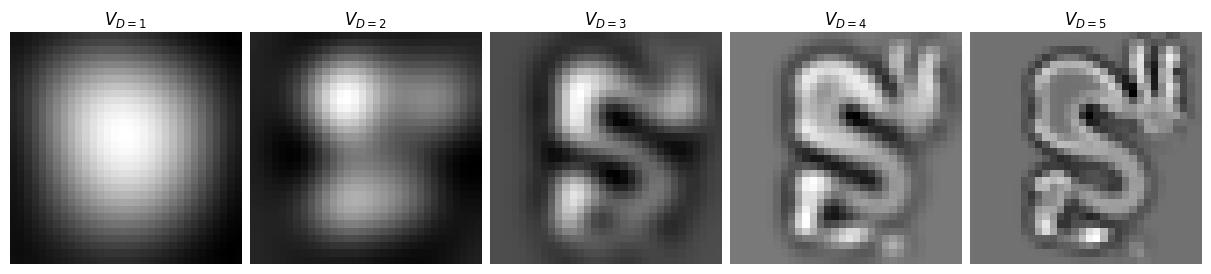

In [94]:
axs = (plt.figure(constrained_layout=True,figsize=(1000//80,1000//80))
       .subplots(1, 5, sharex=False, sharey=False))



axs[0].imshow(dico_grad[1][:,:,16],cmap="gray")
axs[0].set_title('$V_{D=1}$')
axs[0].set_axis_off()
axs[1].imshow(dico_grad[2][:,:,16],cmap="gray")
axs[1].set_title('$V_{D=2}$')
axs[1].set_axis_off()
axs[2].imshow(dico_grad[3][:,:,16],cmap="gray")
axs[2].set_title('$V_{D=3}$')
axs[2].set_axis_off()
axs[3].imshow(dico_grad[4][:,:,16],cmap="gray")
axs[3].set_title('$V_{D=4}$')
axs[3].set_axis_off()
axs[4].imshow(dico_grad[5][:,:,16],cmap="gray")
axs[4].set_title('$V_{D=5}$')
axs[4].set_axis_off()


# List of Gaussian kernels

In [108]:
def get_list_gaussians(l_d,dico):
    res=dict()

    for node in tqdm(dico):
        depth,o_c,o_w,border,border_father,l_points=dico[node]

        tmp_vec=torch.zeros((1,4))
        tmp_vec[0,:3]=o_c.clone()
        tmp_vec[0,3]=o_w
        if depth in l_d:
            
            if depth in res:
                res[depth] = torch.cat((res[depth],tmp_vec), dim=0)
            else:
                res[depth]=torch.empty(0,4)
                res[depth] = torch.cat((res[depth],tmp_vec), dim=0)
    return res
        
        

In [109]:
dico_gaussians=get_list_gaussians([1,2,3,4,5],dico)

100%|████████████████████████████████| 430752/430752 [00:12<00:00, 34080.43it/s]


# Computation of < B , V >

In [207]:
def get_inner_product_gradVB_batched(V, L_gaussians, borders, batch_size=64,desc=None):
    V=V.to(device)
    # Assuming points_c is defined elsewhere and available here
    min_x = torch.min(points_c[:, 0]).item()
    max_x = torch.max(points_c[:, 0]).item()
    min_y = torch.min(points_c[:, 1]).item()
    max_y = torch.max(points_c[:, 1]).item()
    min_z = torch.min(points_c[:, 2]).item()
    max_z = torch.max(points_c[:, 2]).item()

    w_x = max_x - min_x
    w_y = max_y - min_y
    w_z = max_z - min_z

    resolution = V.shape[0]

    x_range = torch.linspace(min_x, max_x, resolution)
    y_range = torch.linspace(min_y, max_y, resolution)
    z_range = torch.linspace(min_z, max_z, resolution)

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')
    
    # Pre-compute the grid coordinates
    grid_coords = torch.stack([grid_x, grid_y, grid_z], dim=-1).to(device)

    res = torch.empty(L_gaussians.shape[0], device=device)
    
    num_batches = (L_gaussians.shape[0] + batch_size - 1) // batch_size

    for b in tqdm(range(num_batches),desc=desc):
        start_idx = b * batch_size
        end_idx = min((b + 1) * batch_size, L_gaussians.shape[0])
        batch = L_gaussians[start_idx:end_idx].to(device)

        tmp_sum_g = ((grid_coords[..., 0:1] - batch[:, 0:1].T) / batch[:, 3:4].T) ** 2
        tmp_sum_g += ((grid_coords[..., 1:2] - batch[:, 1:2].T) / batch[:, 3:4].T) ** 2
        tmp_sum_g += ((grid_coords[..., 2:3] - batch[:, 2:3].T) / batch[:, 3:4].T) ** 2
        
        tmp_sum_g = torch.exp(-(tmp_sum_g / (1.5 ** 2))) / batch[:, 3:4].T ** 3
        tmp_sum_g = tmp_sum_g * V.unsqueeze(-1)  # Add an extra dimension for broadcasting

        # Sum over the grid dimensions and multiply by volume element
        tmp_sum_g = torch.sum(tmp_sum_g, dim=(0, 1, 2)) * ((w_x * w_y * w_z) / resolution ** 3)
        res[start_idx:end_idx] = tmp_sum_g.detach().cpu()

    # Cleanup
    V = V.detach().cpu()
    L_gaussians = L_gaussians.detach().cpu()
    torch.cuda.empty_cache()
    gc.collect()

    return res

def get_VB_d(dico_grad,dico_gaussians,bord):
    res_Vo=dict()

    for d in dico_grad:
        tmp_V=dico_grad[d]
        tmp_L_gauss=dico_gaussians[d]
        V_o=get_inner_product_gradVB_batched(tmp_V,tmp_L_gauss,bord,desc="Computation of V_o D="+str(d))
        res_Vo[d]=V_o.view((V_o.shape[0],1))
        
    return res_Vo
        

In [208]:
dico_VB_d=get_VB_d(dico_grad,dico_gaussians,bord)

Computation of V_o D=5: 100%|███████████████| 283/283 [00:00<00:00, 2502.41it/s]


# Computation of < B'' , B >

In [213]:
def get_indexes_BB(tmp_ker,L_gaussians):
    tmp_L_g=L_gaussians.clone()
    
    tmp_L_g=torch.sqrt(torch.sum((tmp_L_g[:,:3]-tmp_ker[:3])**2,dim=(1)))/tmp_ker[3]
    b= tmp_L_g <=15

    return b.nonzero().flatten()


def get_vec_idxs(L_gaussians_d,L_gaussians_d_prime):
    vec_ixds=torch.empty((0,2))
    
    for idx_gaussian_1 in range(L_gaussians_d.shape[0]):
        indexes=None
        
        indexes=get_indexes_BB(L_gaussians_d[idx_gaussian_1],L_gaussians_d_prime)
            
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,1]=idx_gaussian_1
        tmp_list[:,0]=indexes
        vec_ixds=torch.cat((vec_ixds,tmp_list),0)

    return vec_ixds


In [268]:
def get_inner_product_gradB_B_sparse_vec(size_grid,vec_ixds, L_d,L_d_prime, borders):
    
    sparse_indexes = torch.empty((2,0))
    sparse_values  = torch.empty(0)

    batch_size=256

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()
    min_z=borders[4].item()
    max_z=borders[5].item()

    width_x = max_x - min_x
    width_y = max_y - min_y
    width_z = max_z - min_z

    xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=size_grid)
    ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=size_grid)
    zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=size_grid)
    
    x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

    grid = torch.empty(size_grid, size_grid, size_grid, 3)
    grid[:, :, :, 0] = x
    grid[:, :, :, 1] = y
    grid[:, :, :, 2] = z

    

    
    
    for batch in tqdm(range(0,vec_ixds.shape[0],batch_size)):

        
        Width_d=L_d[0,3]
        Width_d_prime=L_d_prime[0,3]
        
        coords_g1=L_d[vec_ixds[batch:batch+batch_size,1].to(torch.int)].to(device)
        coords_g1=coords_g1[:,:3].unsqueeze(1).unsqueeze(1).unsqueeze(1).expand((-1,size_grid,size_grid,size_grid,-1))
        coords_g2=L_d_prime[vec_ixds[batch:batch+batch_size,0].to(torch.int)].to(device)
        coords_g2=coords_g2[:,:3].unsqueeze(1).unsqueeze(1).unsqueeze(1).expand((-1,size_grid,size_grid,size_grid,-1))

        taille_batch = coords_g2.shape[0]
        grid_tmp= grid.clone().to(device).unsqueeze(0).repeat((taille_batch, 1, 1, 1, 1))

        
        gauss_1=( (grid_tmp.clone()-coords_g1) / Width_d )**2
        gauss_1= torch.exp(-torch.sum(gauss_1,dim=4)/(1.5**2))
        gauss_1x= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 0]-coords_g1[:, :, :, :, 0])/(1.5**2))/Width_d**3
        gauss_1y= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 1]-coords_g1[:, :, :, :, 1])/(1.5**2))/Width_d**3
        gauss_1z= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 2]-coords_g1[:, :, :, :, 2])/(1.5**2))/Width_d**3

        gauss_2=( (grid_tmp.clone()-coords_g2) / Width_d_prime )**2
        gauss_2= torch.exp(-torch.sum(gauss_2,dim=4)/(1.5**2))
        gauss_2x= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 0]-coords_g2[:, :, :, :, 0])/(1.5**2)))/Width_d_prime**3
        gauss_2y= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 1]-coords_g2[:, :, :, :, 1])/(1.5**2)))/Width_d_prime**3
        gauss_2z= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 2]-coords_g2[:, :, :, :, 2])/(1.5**2)))/Width_d_prime**3
        

        
        
        tmp_res=-torch.sum(gauss_1x*gauss_2x*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))
        tmp_res+=-torch.sum(gauss_1y*gauss_2y*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))
        tmp_res+=-torch.sum(gauss_1z*gauss_2z*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))

        
        sparse_indexes = torch.cat((sparse_indexes,vec_ixds[batch:batch+batch_size].permute(1,0).flip([0]) ), dim=1)
        sparse_values = torch.cat((sparse_values, tmp_res.detach().cpu()), dim=0)


    sparse_indexes=sparse_indexes.detach().cpu()
    sparse_values=sparse_values.detach().cpu()
     
    torch.cuda.empty_cache()
    gc.collect()

    return sparse_indexes, sparse_values

        
        

def get_A_dd(l_d,dico_gaussians,dico_VB_d,borders):
    res_AA=dict()

    for d in l_d:
        for d_prime in l_d:
            
            if d_prime > d:
                break

            
            indexes=get_vec_idxs(dico_gaussians[d],dico_gaussians[d_prime])
            

            size_d=dico_VB_d[d].shape[0]
            size_d_prime=dico_VB_d[d_prime].shape[0]

            print("Computation of "+str(d)+"  "+str(d_prime),"   size d: ",size_d," size d_prime ",size_d_prime)

            

            sparse_indexes, sparse_values=get_inner_product_gradB_B_sparse_vec(64,indexes,dico_gaussians[d],dico_gaussians[d_prime], borders)
            
            sparse_indexes=sparse_indexes.to(int)
            sparse_values=sparse_values
         
            res_AA[(d,d_prime)]=torch.sparse_coo_tensor(sparse_indexes, sparse_values,size=(size_d, size_d_prime))
            
            
            
    return res_AA
            








In [269]:
dico_AA=get_A_dd([1,2,3,4,5],dico_gaussians,dico_VB_d,bord)
#loo_indexes,loo_values=get_inner_product_gradB_B_sparse_vec(8,vec_ixds, L_gaussians, bord,Depth_gauss)
#loo_indexes,loo_values=get_Loo(L_gaussians,Depth_gauss,bord)

Computation of 1  1    size d:  32  size d_prime  32


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 30.61it/s]


Computation of 2  1    size d:  184  size d_prime  32


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 30.78it/s]


Computation of 2  2    size d:  184  size d_prime  184


100%|█████████████████████████████████████████| 133/133 [00:04<00:00, 30.95it/s]


Computation of 3  1    size d:  928  size d_prime  32


100%|█████████████████████████████████████████| 114/114 [00:03<00:00, 30.87it/s]


Computation of 3  2    size d:  928  size d_prime  184


 37%|███████████████▏                         | 244/658 [00:08<00:13, 30.48it/s]


KeyboardInterrupt: 

# Linear system solving

In [ ]:
from scipy.sparse.linalg import cg
def get_x(ld,dico_AA,dico_VB):
    res_x=dict()

    for d in ld:
        for d_prime in ld:
            if d_prime>=d:
                break
            tmp_vb=dico_VB[d].to(device)
            tmp_add=dico_AA[(d,d_prime)].to(device)
            tmp_x=res_x[d_prime].to(device)
            dico_VB[d]=tmp_vb.to(device)-torch.mm(tmp_add,tmp_x)

        tmp_A=dico_AA[(d,d)]
        tmp_values=tmp_A._values().clone().detach().cpu().numpy()
        tmp_indexes=tmp_A._indices().clone().detach().cpu().numpy()
        A=scipy.sparse.coo_matrix((tmp_values, tmp_indexes), shape=(tmp_A.shape[0],tmp_A.shape[1]))
        B=dico_VB[d].detach().cpu().clone().numpy()

        eps, exit_code = cg(A, B, tol=1e-1)
        print("exit code at ",d,"   ",d_prime,"   ",exit_code)
        res_x[d]=torch.from_numpy(eps).view((eps.shape[0],1))
    return res_x
        
        
            

In [ ]:
get_x([1,2,3,4,5],dico_AA,dico_VB_d)

In [37]:
#grid resolution
n_p=128

min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

width_x=max_x-min_x
width_y=max_y-min_y
width_z=max_y-min_z

image_res=torch.zeros((n_p,n_p,n_p))

xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=n_p)
ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=n_p)
zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=n_p)

x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

grid = torch.empty(n_p, n_p, n_p, 3)
grid[:, :, :, 0] = x
grid[:, :, :, 1] = y
grid[:, :, :, 2] = z


def get_X(x,l_g,q):
    
    res=torch.sum(torch.exp((-torch.sum(((q.to(device)-l_g[:,:3]).to(device)/l_g[0,3].to(device))**2,dim=1))/1.5**2)*x)
    
    
    return res
        


L_gaussians=L_gaussians.to(device) 
eps=eps.clone().to(device) 


for i in tqdm(range(xs.shape[0])):
    for j in range(xs.shape[0]):
        for w in range(xs.shape[0]):
        
            image_res[i,j,w]=get_X(eps,L_gaussians,grid[i,j,w].to(device) ).detach().cpu()

def get_isovalue(eps,l_g,l_p):
     res=torch.zeros(l_p.shape)
     for idx_p in tqdm(range(l_p.shape[0])):
         tmp_p=l_p[idx_p,:3]
         res[idx_p]=get_X(eps,l_g,tmp_p)
     return res.mean()

iso_val=get_isovalue(eps,L_gaussians,points_c)
print(iso_val)

100%|██████████| 100250/100250 [00:13<00:00, 7265.64it/s]

tensor(-0.9148)


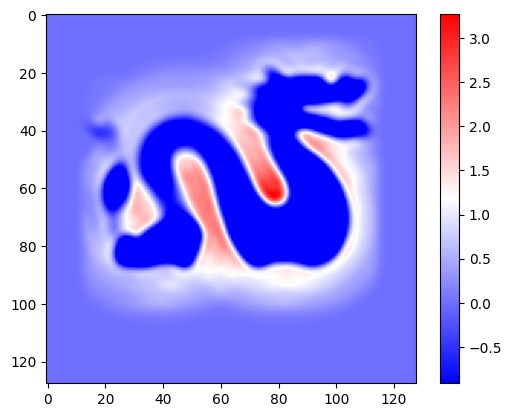

In [39]:
slice=64
plt.imshow(torch.flip(image_res[:,:,slice], dims=[0, 1]),cmap="bwr",vmin=iso_val)
plt.colorbar()

# Export the isovalue as an .Obj file

In [51]:
import numpy as np
import mcubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(image_res.numpy(),iso_val)
mcubes.export_obj(verts, faces, 'dragoon_maison.obj')
